# Predicting CAGE-tags

This notebook illustrates the use of Janggu for prediction CAGE-tag intensity at promoters from the DNA sequence and chromatin features.

In [1]:
#!pip install rpy2
#!pip install tzlocal
#!conda install --yes -c bioconda bedtools samtools 

In [2]:
import os
%load_ext rpy2.ipython

from IPython.display import Image

In [3]:
datadir = '../data'


Run CAGE tag prediction with different sequence encoding orders.
This part is rather time consuming, to rerun this step, remove the hashtags.

In [4]:
#!CUDA_VISIBLE_DEVICES=1 python cage_prediction.py -inputpath {datadir} -order 1
#!CUDA_VISIBLE_DEVICES=1 python cage_prediction.py -inputpath {datadir} -order 2
#!CUDA_VISIBLE_DEVICES=1 python cage_prediction.py -inputpath {datadir} -order 3

Illustrate the correlation between predicted and measured CAGE signal

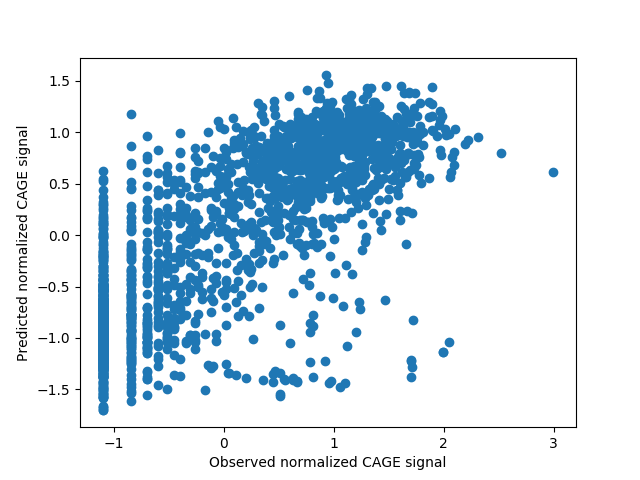

In [5]:
Image(os.path.join('../results_cage_promoters_order3', 'cage_promoter_testchrom_agreement.png'))

## Summary of the performances

In [13]:
%%R
cage1 = read.table("../results_cage_promoters_order1/gridsearch_cage_prediction.tsv", stringsAsFactors=F)
cage2 = read.table("../results_cage_promoters_order2/gridsearch_cage_prediction.tsv", stringsAsFactors=F)
cage3 = read.table("../results_cage_promoters_order3/gridsearch_cage_prediction.tsv", stringsAsFactors=F)

df = rbind(cage1,cage2, cage3)
df = subset(df, pretrained == "randominit")
df$model=""

df$model[df$inputs=="dna_only"] = 'DNA'
df$model[df$inputs=="epi_only"] = 'Chromatin'
df$model[df$inputs=="epi_dna"] = 'Chromatin+DNA'

#print(df)

df = df[,c(4, 6, 9)]

se = function(x) sd(x)/sqrt(length(x))

cor_mean = aggregate(df[,2], by=df[,c(1, 3)], FUN=mean)
names(cor_mean)[3]= "cor_mean"
cor_se = aggregate(df[,2], by=df[,c(1, 3)], FUN=se)
cor_mean["cor_se"] = cor_se[3]

print(cor_mean)

  dnaorder         model  cor_mean       cor_se
1        1     Chromatin 0,7765064 0,0001087741
2        2     Chromatin 0,7761053 0,0004707447
3        3     Chromatin 0,7765084 0,0001834439
4        1 Chromatin+DNA 0,7760822 0,0004634718
5        2 Chromatin+DNA 0,7816203 0,0006578620
6        3 Chromatin+DNA 0,7826437 0,0006326636
7        1           DNA 0,5376792 0,0040952490
8        2           DNA 0,5585536 0,0070128584
9        3           DNA 0,5878622 0,0033954591


In [14]:
%R library(ggplot2)

array(['ggplot2', 'tools', 'stats', 'graphics', 'grDevices', 'utils',
       'datasets', 'methods', 'base'], dtype='<U9')

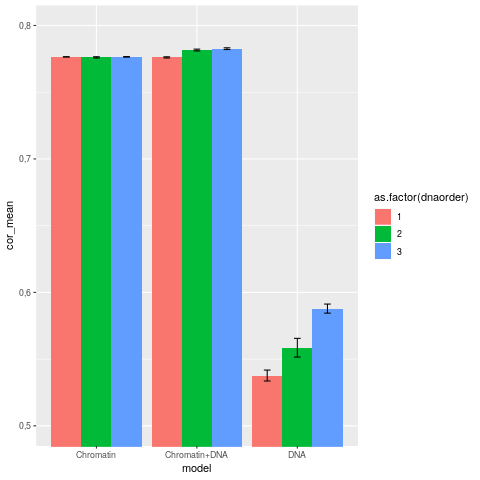

In [15]:
%%R

ggplot(cor_mean, aes(x=model, y=cor_mean, fill=as.factor(dnaorder))) +
      geom_bar(position=position_dodge(), stat="identity") +
      coord_cartesian(ylim=c(.50,.8)) +
      geom_errorbar(aes(ymin=cor_mean-cor_se, ymax=cor_mean+cor_se),
                    width=.2, position=position_dodge(.9))

